# MVP Notebook Daniel

In [251]:
import preprocessing
import wrangle
import model

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score


# ignore warnings
import warnings
warnings.simplefilter(action='ignore')

import os.path
from os import path

import re

In [2]:
df = preprocessing.get_model_df()

In [3]:
df

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label
0,Bronx,NY,2013,8,822430600,1.028038e+08,24774500.0,NaN,NaN,NaN,NaN,False
1,Trenton,NJ,2009,3,760934400,2.536448e+08,4100000.0,1.0,755874500.0,755874500.0,755874500.0,False
2,New York,NY,2013,6,616362504,1.027271e+08,18382352.0,1.0,9364704.0,9364704.0,9364704.0,False
3,Chicago,IL,2012,44,510069300,1.159248e+07,7710000.0,NaN,NaN,NaN,NaN,False
4,Chicago,IL,2011,41,462365300,1.127720e+07,8677500.0,1.0,5387000.0,5387000.0,5387000.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
13502,Albany,GA,2008,1,152400,1.524000e+05,152400.0,NaN,NaN,NaN,NaN,False
13503,Cordele,GA,2008,1,145000,1.450000e+05,145000.0,NaN,NaN,NaN,NaN,False
13504,Covington,KY,2006,1,125000,1.250000e+05,125000.0,NaN,NaN,NaN,NaN,False
13505,Wolcottville,IN,2017,1,114000,1.140000e+05,114000.0,NaN,NaN,NaN,NaN,False


In [4]:
df = preprocessing.add_new_features(df)

In [5]:
def filter_top_cities(df):

    df["city_state"] = df["city"] + "_" + df["state"]

    city_mask = df.groupby("city_state").year.count()

    city_mask = city_mask[city_mask == 15]

    # apply city mask to shrink the df
    def in_city_mask(x):
        return x in city_mask
    df = df[df.city_state.apply(in_city_mask)]

    df = df.sort_values(["city", "state", "year"])
    
    return df

In [6]:
df = filter_top_cities(df)

## <span style='background :yellow' > Adding the labeling </span>

In [7]:
# # Using the Evolution Index as a label:
# # For values that are higher than 100% in evolution index.

# df["ei_label"] = np.where(df.ei > 1, 1, 0)

In [8]:
# using future data to create the labels

def labeling_future_data(df):
    """this function takes in a data frame and returns a boolean column that identifies
    if a city_state_year is a market that should be entered"""
    df["label_quantity_of_mortgages_pop_2y"] = (df.sort_values(["year"])
                                  .groupby(["city", "state"])[["quantity_of_mortgages_pop"]]
                                  .pct_change(2)
                                  .shift(-2))
    df["label_total_mortgage_volume_pop_2y"] = (df.sort_values(["year"])
                                  .groupby(["city", "state"])[["total_mortgage_volume_pop"]]
                                  .pct_change(2)
                                  .shift(-2))
    Q3 = df.label_quantity_of_mortgages_pop_2y.quantile(.75)
    Q1 = df.label_quantity_of_mortgages_pop_2y.quantile(.25)
    upper_fence_quantity = Q3 + ((Q3-Q1)*1.5)
    upper_fence_quantity
    Q3 = df.label_total_mortgage_volume_pop_2y.quantile(.75)
    Q1 = df.label_total_mortgage_volume_pop_2y.quantile(.25)
    upper_fence_volume = Q3 + ((Q3-Q1)*1.5)
    upper_fence_volume
    df['should_enter'] = (df.label_total_mortgage_volume_pop_2y > upper_fence_volume) | (df.label_quantity_of_mortgages_pop_2y > upper_fence_quantity)
    return df

In [9]:
df = labeling_future_data(df)

In [10]:
df.should_enter.value_counts()

False    339
True      51
Name: should_enter, dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 1474 to 151
Data columns (total 23 columns):
city                                  390 non-null object
state                                 390 non-null object
year                                  390 non-null int64
quantity_of_mortgages_pop             390 non-null int64
total_mortgage_volume_pop             390 non-null int64
average_mortgage_volume_pop           390 non-null float64
median_mortgage_amount_pop            390 non-null float64
quantity_of_mortgages_nc              179 non-null float64
total_mortgage_volume_nc              179 non-null float64
average_mortgage_volume_nc            179 non-null float64
median_mortgage_amount_nc             179 non-null float64
label                                 390 non-null bool
city_state_vol_delta_pop              364 non-null float64
city_state_vol_delta_nc               310 non-null float64
city_state_qty_delta_pop              364 non-null float64
city_state_qty_del

In [12]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

In [13]:
def train_test_data(df):
    train, test = train_test_split(df, train_size=.75, random_state=123, stratify = df["should_enter"])
    return train, test

#__Main Pre-modeling function__#
def prep_data_for_modeling(df, features_for_modeling, label_feature):

    # To avoid Nan's, I have removed all data from 2006 (because all the var's would be nan)
    df_model = df[df.year > 2007]

    # Create an observation id to reduce the chance of mistake's
    df_model["observation_id"] = df_model.city + "_" + df_model.state + "_"  + df_model.year.astype(str)

    # select that features that we want to model, and use our observation id as the row id
    features_for_modeling += ["observation_id"]
    features_for_modeling += [label_feature]
    data = df_model[features_for_modeling].set_index("observation_id")

    train, test = train_test_data(data)
    train = train.sort_values("observation_id")
    test = test.sort_values("observation_id")

    X_train = train.drop(columns=label_feature)
    y_train = train[label_feature]
    X_test = test.drop(columns=label_feature)
    y_test = test[label_feature]

    return X_train, y_train, X_test, y_test

In [14]:
features_for_modeling = ["quantity_of_mortgages_pop", "city_state_qty_delta_pop", "ei", "median_mortgage_amount_pop"]
label_feature = "should_enter"
X_train, y_train, X_test, y_test = prep_data_for_modeling(df, features_for_modeling, label_feature)

In [15]:
# Helper function used to updated the scaled arrays and transform them into usable dataframes
def return_values(scaler, train, test):
    train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns.values).set_index([train.index.values])
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns.values).set_index([test.index.values])
    return scaler, train_scaled, test_scaled

# Linear scaler
def min_max_scaler(train, test):
    scaler = MinMaxScaler().fit(train)
    scaler, train_scaled, test_scaled = return_values(scaler, train , test)
    return scaler, train_scaled, test_scaled

In [16]:
# Scaler is ready - in case we need it

scaler, train_scaled, test_scaled = min_max_scaler(X_train, X_test)

In [17]:
assert(train_scaled.shape[1] == test_scaled.shape[1])

In [18]:
train_scaled.head()

,quantity_of_mortgages_pop,city_state_qty_delta_pop,ei,median_mortgage_amount_pop
Atlanta_GA_2008,0.023256,0.012324,0.006500,0.033455
Atlanta_GA_2010,0.232558,0.087637,0.017727,0.056728
Atlanta_GA_2011,0.209302,0.063380,0.020123,0.045856
Atlanta_GA_2012,0.255814,0.085915,0.021484,0.031960
Atlanta_GA_2014,0.232558,0.037806,0.031682,0.053211


In [19]:
train_scaled.isnull().sum()

quantity_of_mortgages_pop     0
city_state_qty_delta_pop      0
ei                            0
median_mortgage_amount_pop    0
dtype: int64

In [20]:
grid, df_result, best_model = model.run_decision_tree_cv(train_scaled, y_train)

{'criterion': 'gini', 'max_depth': 10, 'score': 0.20726495726495728}


In [21]:
grid, df_result, best_model = model.run_random_forest_cv(train_scaled, y_train)

{'max_depth': 3, 'min_samples_leaf': 1, 'score': 0.07692307692307693}


In [22]:
grid, df_result, best_model = model.run_knn_cv(train_scaled, y_train)

{'n_neighbors': 3, 'weights': 'uniform', 'score': 0.12820512820512822}


----

# Evaluation

In [23]:
grid, df_result, best_model = model.run_decision_tree_cv(train_scaled, y_train)

{'criterion': 'entropy', 'max_depth': 10, 'score': 0.18376068376068377}


In [24]:
y_pred = best_model.predict(train_scaled)

In [25]:
labels = sorted(y_train.unique())
matrix = pd.DataFrame(confusion_matrix(y_train, y_pred), index = labels, columns = labels)

In [26]:
recall_score(y_train, y_pred)

0.8157894736842105

In [27]:
print(matrix)

       False  True 
False    215      0
True       7     31


In [28]:
best_model.score(test_scaled, y_test)

0.8352941176470589

In [29]:
y_pred = best_model.predict(test_scaled)

In [30]:
labels = sorted(y_train.unique())
matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), index = labels, columns = labels)

In [31]:
recall_score(y_test, y_pred)

0.07692307692307693

In [32]:
print(matrix)

       False  True 
False     70      2
True      12      1


In [33]:
best_model.score(train_scaled, y_train)

0.9723320158102767

In [34]:
y_train

observation_id
Atlanta_GA_2008       False
Atlanta_GA_2010        True
Atlanta_GA_2011       False
Atlanta_GA_2012        True
Atlanta_GA_2014       False
                      ...  
Washington_DC_2015    False
Washington_DC_2017    False
Washington_DC_2018    False
Washington_DC_2019    False
Washington_DC_2020    False
Name: should_enter, Length: 253, dtype: bool

----

# Prediction

In [35]:
model_df = preprocessing.get_model_df()

df["city_state"] = df["city"] + "_" + df["state"]

city_mask = df.groupby("city_state").year.count()

city_mask = city_mask[city_mask == 15]

# apply city mask to shrink the df
def in_city_mask(x):
    return x in city_mask
df = df[df.city_state.apply(in_city_mask)]

df = preprocessing.add_new_features(df)

df = df.sort_values(["city", "state", "year"])

In [36]:
df.head()

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,...,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state,label_quantity_of_mortgages_pop_2y,label_total_mortgage_volume_pop_2y,should_enter
1474,Atlanta,GA,2006,6,33186800,5.531133e+06,4457100.0,2.0,9181100.0,4590550.0,...,NaN,NaN,NaN,949218636,NaN,NaN,Atlanta_GA,NaN,NaN,False
1850,Atlanta,GA,2007,8,28277600,3.534700e+06,3031150.0,2.0,4541700.0,2270850.0,...,-0.505321,0.333333,0.0,890838500,-0.061503,0.907913,Atlanta_GA,NaN,NaN,False
7566,Atlanta,GA,2008,2,6735000,3.367500e+06,3367500.0,1.0,4950000.0,4950000.0,...,0.089900,-0.750000,-0.5,404334500,-0.546119,0.524751,Atlanta_GA,0.0,-0.812906,False
752,Atlanta,GA,2009,9,49972900,5.552544e+06,4400000.0,1.0,3750000.0,3750000.0,...,-0.242424,3.500000,0.0,1090026900,1.695854,2.752330,Atlanta_GA,4.5,9.213569,True
449,Atlanta,GA,2010,11,68788385,6.253490e+06,5196100.0,2.0,7203500.0,3601750.0,...,0.920933,0.222222,1.0,2531197385,1.322142,0.592778,Atlanta_GA,4.5,14.076042,True


In [37]:
features_for_predicting = ["quantity_of_mortgages_pop", "city_state_qty_delta_pop", "ei", "median_mortgage_amount_pop"]

In [38]:
predictions = df[(df.year == 2020) | (df.year == 2019)].groupby("city_state")[features_for_predicting].mean()
predictions

,quantity_of_mortgages_pop,city_state_qty_delta_pop,ei,median_mortgage_amount_pop
city_state,,,,
Atlanta_GA,2.5,-0.208333,0.841829,14743525.0
Austin_TX,4.0,-0.250000,1.437714,27422850.0
Baltimore_MD,6.5,-0.420833,0.838642,12466625.0
Boston_MA,12.5,-0.023810,1.135973,11158750.0
Chicago_IL,11.0,-0.311741,1.084084,12010100.0
Cincinnati_OH,5.5,0.633333,2.418846,8620350.0
Cleveland_OH,2.0,0.571429,1.127698,9025000.0
Dallas_TX,4.0,-0.166667,1.278336,30065025.0
Detroit_MI,2.0,0.583333,5.959439,19445600.0


In [39]:
# Helper function used to updated the scaled arrays and transform them into usable dataframes
def return_values_prediction(scaler, df):
    train_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns.values).set_index([df.index.values])
    return scaler, train_scaled

# Linear scaler
def min_max_scaler_prediction(df):
    scaler = MinMaxScaler().fit(df)
    scaler, df_scaled = return_values_prediction(scaler, df)
    return scaler, df_scaled

In [40]:
scaler, predictions_scaled = min_max_scaler_prediction(predictions)

In [41]:
predictions["label"] = best_model.predict(predictions_scaled)

In [42]:
predictions

,quantity_of_mortgages_pop,city_state_qty_delta_pop,ei,median_mortgage_amount_pop,label
city_state,,,,,
Atlanta_GA,2.5,-0.208333,0.841829,14743525.0,False
Austin_TX,4.0,-0.250000,1.437714,27422850.0,False
Baltimore_MD,6.5,-0.420833,0.838642,12466625.0,False
Boston_MA,12.5,-0.023810,1.135973,11158750.0,False
Chicago_IL,11.0,-0.311741,1.084084,12010100.0,False
Cincinnati_OH,5.5,0.633333,2.418846,8620350.0,False
Cleveland_OH,2.0,0.571429,1.127698,9025000.0,True
Dallas_TX,4.0,-0.166667,1.278336,30065025.0,False
Detroit_MI,2.0,0.583333,5.959439,19445600.0,True


In [43]:
city = predictions.reset_index().city_state.str.split("_", n=1, expand=True)[0]

state = predictions.reset_index().city_state.str.split("_", n=1, expand=True)[1]

In [44]:
predictions = predictions.reset_index()

In [45]:
predictions["city"] = city

predictions["state"] = state

In [46]:
predictions

,city_state,quantity_of_mortgages_pop,city_state_qty_delta_pop,ei,median_mortgage_amount_pop,label,city,state
0,Atlanta_GA,2.5,-0.208333,0.841829,14743525.0,False,Atlanta,GA
1,Austin_TX,4.0,-0.250000,1.437714,27422850.0,False,Austin,TX
2,Baltimore_MD,6.5,-0.420833,0.838642,12466625.0,False,Baltimore,MD
3,Boston_MA,12.5,-0.023810,1.135973,11158750.0,False,Boston,MA
4,Chicago_IL,11.0,-0.311741,1.084084,12010100.0,False,Chicago,IL
5,Cincinnati_OH,5.5,0.633333,2.418846,8620350.0,False,Cincinnati,OH
6,Cleveland_OH,2.0,0.571429,1.127698,9025000.0,True,Cleveland,OH
7,Dallas_TX,4.0,-0.166667,1.278336,30065025.0,False,Dallas,TX
8,Detroit_MI,2.0,0.583333,5.959439,19445600.0,True,Detroit,MI
9,Houston_TX,5.0,-0.511364,0.590224,13573625.0,False,Houston,TX


In [47]:
predictions.to_csv("predictions.csv")

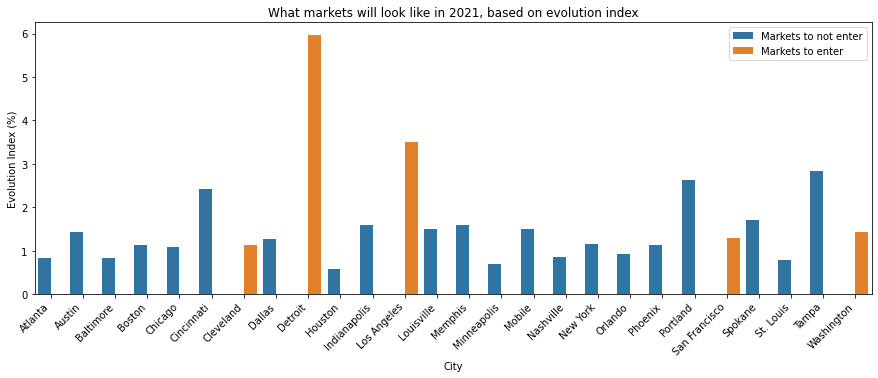

In [48]:
plt.figure(figsize=(15,5))
ax = sns.barplot(data=predictions, x="city", y="ei", hue="label")
plt.title("What markets will look like in 2021, based on evolution index")
plt.xticks(rotation=45, ha="right")
plt.xlabel("City")
plt.ylabel("Evolution Index (%)")
new_labels = ['Markets to not enter', 'Markets to enter']
h, l = ax.get_legend_handles_labels()
ax.legend(h, new_labels)
plt.show()

# Notes for improvement:

* Calculate modeling by hand
* use oversampling to increase number of positive occurences.
* Look at the docs to stratify the data better in cross validation

-----

# Modeling

We will be using classification algorithms to predict what markets will be hot as of 2020/2021. This will help us create recommendations for the future, so that we know what market's will be worth investing resources and labor in, and what martek's are worth ignoring.

We will be likely using the following features for modeling:

```python
features_for_modeling = ["quantity_of_mortgages_pop", "city_state_qty_delta_pop", "ei", "median_mortgage_amount_pop"]
```

Our target variable (the variable we are trying to predict, will be:

```python
label_feature = "should_enter"
```

In this case, our positive case will be `should_enter_market`. 


When looking at our confusion matrix, and all of it's possible outcomes, it would likely look as follows:

| Matrix | Actual Positive | Actual Negative |
|--------|-----------------|-----------------|
| Predicted Positive | `enter_market` | predicted `not_enter_market`, but really it was a hot market and a missed opportunity | 
| Predicted Negative | predicted `enter_market`, but really it was a cold market, and not worth investing | `not_enter_market`


Traditionally, for a project like this one, we would have focus on reducing the number of `False_Positives`, because it would be far more expensive to the stakeholder if we predicted a city was going to be hot, they spend time and money, and their investment is not returned. However, because TestFit's business strategy and software deployment are all done online, with very little investment needed for traveling. This means that actually investing in a city is not costly at all. As such, we will optimize our models to reduce the number of `False_Negtives`, because we want to make sure we are not missing any potential markets that can be considered `hot markets` in 2020 and 2021.

Given that we have a low number of `positive` labels in our data, we will have to do something called **Oversampling**. This is a practice use in the field to basically help the predictive model by calling attention to the postiive labels and their patterns. We will create duplicate positive values, so that the model becomes more effective at predicting these values.

In [200]:
def split_data(df, train_size=.75,random_state = 124):
    train, test = train_test_split(df, train_size=train_size, random_state=random_state, stratify = df["should_enter"])
    train, validate = train_test_split(train, train_size=train_size, random_state=random_state, stratify = train["should_enter"])
    return train, validate, test

#__Main Pre-modeling function__#
def prep_data_for_modeling(df, features_for_modeling, label_feature):

    # To avoid Nan's, I have removed all data from 2006 (because all the var's would be nan)
    df_model = df[df.year > 2007]

    # Create an observation id to reduce the chance of mistake's
    df_model["observation_id"] = df_model.city + "_" + df_model.state + "_"  + df_model.year.astype(str)

    # select that features that we want to model, and use our observation id as the row id
    features_for_modeling += ["observation_id"]

    features_for_modeling += [label_feature]

    data = df_model[features_for_modeling].set_index("observation_id")
    
    train, validate, test = split_data(data)
    train = train.sort_values("observation_id")
    validate = validate.sort_values("observation_id")
    test = test.sort_values("observation_id")
    
    
    X_train = train.drop(columns=label_feature)
    y_train = train[label_feature]
    X_validate = validate.drop(columns=label_feature)
    y_validate = validate[label_feature]
    X_test = test.drop(columns=label_feature)
    y_test = test[label_feature]
    

    return X_train, X_validate, X_test, y_train, y_validate, y_test



def return_values(scaler, train, validate, test):
    '''
    Helper function used to updated the scaled arrays and transform them into usable dataframes
    '''
    train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns.values).set_index([train.index.values])
    validate_scaled = pd.DataFrame(scaler.transform(validate), columns=validate.columns.values).set_index([validate.index.values])
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns.values).set_index([test.index.values])
    return scaler, train_scaled, validate_scaled, test_scaled

# Linear scaler
def min_max_scaler(train,validate, test):
    '''
    Helper function that scales that data. Returns scaler, as well as the scaled dataframes
    '''
    scaler = MinMaxScaler().fit(train)
    scaler, train_scaled, validate_scaled, test_scaled = return_values(scaler, train, validate, test)
    return scaler, train_scaled, validate_scaled, test_scaled

In [201]:
df = preprocessing.get_model_df()
df = preprocessing.add_new_features(df)
df = filter_top_cities(df)
df = labeling_future_data(df)

In [202]:
df = df.append(df[df.should_enter])
df = df.append(df[df.should_enter])
df = df.append(df[df.should_enter])

In [203]:
# What percent of the data is positive?
(df.should_enter).mean()

0.5461847389558233

In [204]:
features_for_modeling = ["quantity_of_mortgages_pop", "city_state_qty_delta_pop", "ei", "median_mortgage_amount_pop"]
label_feature = "should_enter"
X_train, X_validate, X_test, y_train, y_validate, y_test = prep_data_for_modeling(df, features_for_modeling, label_feature)

In [205]:
scaler, train_scaled, validate_scaled, test_scaled = min_max_scaler(X_train, X_validate, X_test)

In [206]:
train_scaled

,quantity_of_mortgages_pop,city_state_qty_delta_pop,ei,median_mortgage_amount_pop
Atlanta_GA_2009,0.200,0.341549,0.115473,0.049972
Atlanta_GA_2009,0.200,0.341549,0.115473,0.049972
Atlanta_GA_2009,0.200,0.341549,0.115473,0.049972
Atlanta_GA_2009,0.200,0.341549,0.115473,0.049972
Atlanta_GA_2010,0.250,0.087637,0.017727,0.060839
...,...,...,...,...
Washington_DC_2012,0.100,0.048290,0.007484,0.152486
Washington_DC_2014,0.200,0.046587,0.117894,0.215135
Washington_DC_2015,0.175,0.061815,0.035532,0.218693
Washington_DC_2016,0.175,0.070423,0.034032,0.363268


# Decision Tree

In [207]:
predictions = pd.DataFrame({"actual": y_train, "baseline": y_train.mode()[0]})

In [208]:
for i in range(1, 20):
    clf, y_pred = model.run_clf(train_scaled, y_train, i)
    score = clf.score(train_scaled, y_train)
    validate_score = clf.score(validate_scaled, y_validate)
    _, _, report = model.accuracy_report(clf, y_pred, y_train)
    recall_score = report["True"].recall
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. validate_score = {validate_score:.2f}, recall = {recall_score:.2f}")

Max_depth = 1, accuracy_score = 0.67. validate_score = 0.66, recall = 0.70
Max_depth = 2, accuracy_score = 0.73. validate_score = 0.73, recall = 0.91
Max_depth = 3, accuracy_score = 0.75. validate_score = 0.73, recall = 0.91
Max_depth = 4, accuracy_score = 0.79. validate_score = 0.73, recall = 0.96
Max_depth = 5, accuracy_score = 0.83. validate_score = 0.76, recall = 0.96
Max_depth = 6, accuracy_score = 0.88. validate_score = 0.76, recall = 0.97
Max_depth = 7, accuracy_score = 0.89. validate_score = 0.82, recall = 1.00
Max_depth = 8, accuracy_score = 0.94. validate_score = 0.84, recall = 1.00
Max_depth = 9, accuracy_score = 0.97. validate_score = 0.88, recall = 1.00
Max_depth = 10, accuracy_score = 0.98. validate_score = 0.87, recall = 0.99
Max_depth = 11, accuracy_score = 0.99. validate_score = 0.89, recall = 1.00
Max_depth = 12, accuracy_score = 0.99. validate_score = 0.89, recall = 1.00
Max_depth = 13, accuracy_score = 0.99. validate_score = 0.89, recall = 1.00
Max_depth = 14, accur

In [209]:
clf, y_pred = model.run_clf(train_scaled, y_train, 4)
predictions["decision_tree"] = y_pred

In [210]:
accuracy_score, matrix, report = model.accuracy_report(clf, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.79
       False  True 
False     90     71
True      10    219


,False,True,accuracy,macro avg,weighted avg
precision,0.900000,0.755172,0.792308,0.827586,0.814960
recall,0.559006,0.956332,0.792308,0.757669,0.792308
f1-score,0.689655,0.843931,0.792308,0.766793,0.780243
support,161.000000,229.000000,0.792308,390.000000,390.000000


In [243]:
coef = clf.feature_importances_
# We want to check that the coef array has the same number of items as there are features in our X_train dataframe.
assert(len(coef) == train_scaled.shape[1])
coef = clf.feature_importances_
columns = train_scaled.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

Text(0.5, 1.0, 'What are the most influencial features?')

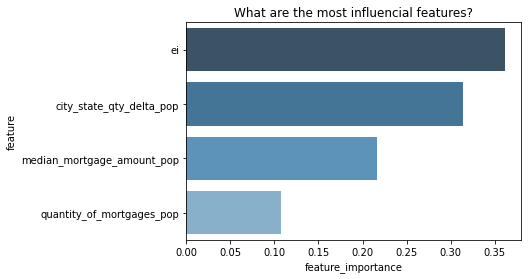

In [244]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")
plt.title("What are the most influencial features?")

Interestingly, it seems that when it comes to decision tree, the `evolution_index` is actually the most indicative feature, along side the change in number of mortgage's approved. The total `quantity_of_mortgages_pop` doesn't seem to be as influencial in the predictions.

# Random Forest

In [245]:
for i in range(1, 20):
    rf, y_pred = model.run_rf(train_scaled, y_train, 1, i)
    score = rf.score(train_scaled, y_train)
    validate_score = rf.score(validate_scaled, y_validate)
    _, _, report = model.accuracy_report(rf, y_pred, y_train)
    recall_score = report["True"].recall
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. validate_score = {validate_score:.2f}, recall = {recall_score:.2f}")

Max_depth = 1, accuracy_score = 0.67. validate_score = 0.60, recall = 0.93
Max_depth = 2, accuracy_score = 0.74. validate_score = 0.76, recall = 0.90
Max_depth = 3, accuracy_score = 0.80. validate_score = 0.79, recall = 0.93
Max_depth = 4, accuracy_score = 0.85. validate_score = 0.81, recall = 0.97
Max_depth = 5, accuracy_score = 0.89. validate_score = 0.84, recall = 0.99
Max_depth = 6, accuracy_score = 0.94. validate_score = 0.88, recall = 1.00
Max_depth = 7, accuracy_score = 0.98. validate_score = 0.90, recall = 1.00
Max_depth = 8, accuracy_score = 0.98. validate_score = 0.91, recall = 1.00
Max_depth = 9, accuracy_score = 0.99. validate_score = 0.92, recall = 1.00
Max_depth = 10, accuracy_score = 1.00. validate_score = 0.93, recall = 1.00
Max_depth = 11, accuracy_score = 1.00. validate_score = 0.92, recall = 1.00
Max_depth = 12, accuracy_score = 1.00. validate_score = 0.93, recall = 1.00
Max_depth = 13, accuracy_score = 1.00. validate_score = 0.92, recall = 1.00
Max_depth = 14, accur

In [212]:
rf, y_pred = model.run_rf(train_scaled, y_train, 1, 3)
predictions["random_forest"] = y_pred

In [213]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.80
       False  True 
False    100     61
True      17    212


,False,True,accuracy,macro avg,weighted avg
precision,0.854701,0.776557,0.8,0.815629,0.808816
recall,0.621118,0.925764,0.8,0.773441,0.800000
f1-score,0.719424,0.844622,0.8,0.782023,0.792938
support,161.000000,229.000000,0.8,390.000000,390.000000


In [241]:
coef = rf.feature_importances_
columns = X_train.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

Text(0.5, 1.0, 'What are the most influencial features?')

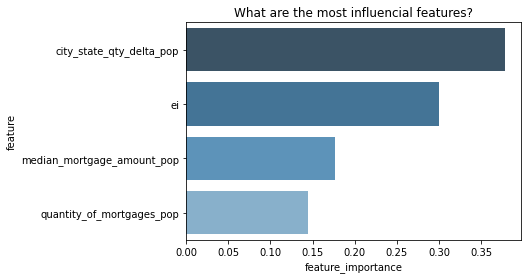

In [242]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")
plt.title("What are the most influencial features?")

Interestingly, for the random_forest model, the delta of the number of loans approved by city where the most important or influencial indicator of whether a city would be `a hot martket` or not. The evolution index was the second most influencial feature. Again, the total `quantity_of_morgages_pop` was the least influencial feature.

# KNN

In [214]:
for i in range(1, 20):
    knn, y_pred = model.run_knn(train_scaled, y_train, i)
    score = knn.score(train_scaled, y_train)
    validate_score = knn.score(validate_scaled, y_validate)
    _, _, report = model.accuracy_report(knn, y_pred, y_train)
    recall_score = report["True"].recall
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. validate_score = {validate_score:.2f}, recall = {recall_score:.2f}")

Max_depth = 1, accuracy_score = 1.00. validate_score = 0.94, recall = 1.00
Max_depth = 2, accuracy_score = 1.00. validate_score = 0.95, recall = 1.00
Max_depth = 3, accuracy_score = 0.92. validate_score = 0.86, recall = 1.00
Max_depth = 4, accuracy_score = 0.91. validate_score = 0.83, recall = 0.98
Max_depth = 5, accuracy_score = 0.84. validate_score = 0.78, recall = 0.98
Max_depth = 6, accuracy_score = 0.84. validate_score = 0.74, recall = 0.94
Max_depth = 7, accuracy_score = 0.80. validate_score = 0.72, recall = 0.95
Max_depth = 8, accuracy_score = 0.77. validate_score = 0.68, recall = 0.86
Max_depth = 9, accuracy_score = 0.76. validate_score = 0.68, recall = 0.88
Max_depth = 10, accuracy_score = 0.71. validate_score = 0.66, recall = 0.71
Max_depth = 11, accuracy_score = 0.72. validate_score = 0.67, recall = 0.77
Max_depth = 12, accuracy_score = 0.72. validate_score = 0.64, recall = 0.75
Max_depth = 13, accuracy_score = 0.75. validate_score = 0.69, recall = 0.85
Max_depth = 14, accur

In [215]:
knn, y_pred = model.run_knn(train_scaled, y_train, 2)
predictions["knn"] = y_pred

In [216]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 1.00
       False  True 
False    161      0
True       0    229


,False,True,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0
support,161.0,229.0,1.0,390.0,390.0


In [217]:
# How do the different models compare on accuracy?
print("Accuracy Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report.accuracy[0]:.2f}')

Accuracy Scores
---------------
Actual = 1.00
Baseline = 0.59
Decision_Tree = 0.79
Random_Forest = 0.80
Knn = 1.00


In [218]:
# How do the different models compare on recall?
print("Recall Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report["True"].loc["recall"]:.2f}')

Recall Scores
---------------
Actual = 1.00
Baseline = 1.00
Decision_Tree = 0.96
Random_Forest = 0.93
Knn = 1.00


In [219]:
# How do the different models compare on recall?
print("Precision Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report["True"].loc["precision"]:.2f}')

Precision Scores
---------------
Actual = 1.00
Baseline = 0.59
Decision_Tree = 0.76
Random_Forest = 0.78
Knn = 1.00


## Conclusion:

Overall, we see that because we have optimized for *recall*, the accuracy scores are a bit lower than expected. However, our recall scores are really good. We will choose the KNN model as the most effective model, given that it consistently achieved the best scores (for accuracy, recall and precision). 

# Evaluate

In [220]:
rf, y_pred = model.run_rf(train_scaled, y_train, 1, 3)

In [221]:
y_pred = rf.predict(test_scaled)

In [222]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_test)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.75
       False  True 
False     45     27
True      16     86


,False,True,accuracy,macro avg,weighted avg
precision,0.737705,0.761062,0.752874,0.749383,0.751397
recall,0.625000,0.843137,0.752874,0.734069,0.752874
f1-score,0.676692,0.800000,0.752874,0.738346,0.748976
support,72.000000,102.000000,0.752874,174.000000,174.000000


---

In [223]:
knn, y_pred = model.run_knn(train_scaled, y_train, 2)

In [224]:
y_pred = knn.predict(test_scaled)

In [225]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_test)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.90
       False  True 
False     55     17
True       0    102


,False,True,accuracy,macro avg,weighted avg
precision,1.000000,0.857143,0.902299,0.928571,0.916256
recall,0.763889,1.000000,0.902299,0.881944,0.902299
f1-score,0.866142,0.923077,0.902299,0.894609,0.899518
support,72.000000,102.000000,0.902299,174.000000,174.000000


----

# Prediction

In [226]:
df = preprocessing.get_model_df()
df = preprocessing.add_new_features(df)
df = filter_top_cities(df)

In [227]:
df.head()

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state
1474,Atlanta,GA,2006,6,33186800,5.531133e+06,4457100.0,2.0,9181100.0,4590550.0,4590550.0,False,NaN,NaN,NaN,NaN,6774129256,NaN,NaN,Atlanta_GA
1850,Atlanta,GA,2007,8,28277600,3.534700e+06,3031150.0,2.0,4541700.0,2270850.0,2270850.0,False,-0.147926,-0.505321,0.333333,0.0,4973263164,-0.265845,1.160618,Atlanta_GA
7566,Atlanta,GA,2008,2,6735000,3.367500e+06,3367500.0,1.0,4950000.0,4950000.0,4950000.0,False,-0.761826,0.089900,-0.750000,-0.5,4444102426,-0.106401,0.266534,Atlanta_GA
752,Atlanta,GA,2009,9,49972900,5.552544e+06,4400000.0,1.0,3750000.0,3750000.0,3750000.0,False,6.419881,-0.242424,3.500000,0.0,7882704846,0.773745,4.183172,Atlanta_GA
449,Atlanta,GA,2010,11,68788385,6.253490e+06,5196100.0,2.0,7203500.0,3601750.0,3601750.0,False,0.376514,0.920933,0.222222,1.0,16193901958,1.054359,0.670046,Atlanta_GA


In [228]:
features_for_predicting = ["quantity_of_mortgages_pop", "city_state_qty_delta_pop", "ei", "median_mortgage_amount_pop"]

In [229]:
predictions = df[(df.year == 2020) | (df.year == 2019)].groupby("city_state")[features_for_predicting].mean()
predictions

,quantity_of_mortgages_pop,city_state_qty_delta_pop,ei,median_mortgage_amount_pop
city_state,,,,
Atlanta_GA,2.5,-0.208333,0.818544,14743525.0
Austin_TX,4.0,-0.250000,1.936679,27422850.0
Baltimore_MD,6.5,-0.420833,0.966084,12466625.0
Boston_MA,12.5,-0.023810,1.126264,11158750.0
Chicago_IL,11.0,-0.311741,0.981413,12010100.0
Cincinnati_OH,5.5,0.633333,2.959727,8620350.0
Cleveland_OH,2.0,0.571429,1.566514,9025000.0
Dallas_TX,4.0,-0.166667,1.303434,30065025.0
Detroit_MI,2.0,0.583333,8.755146,19445600.0


In [230]:
# Helper function used to updated the scaled arrays and transform them into usable dataframes
def return_values_prediction(scaler, df):
    train_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns.values).set_index([df.index.values])
    return scaler, train_scaled

# Linear scaler
def min_max_scaler_prediction(df):
    scaler = MinMaxScaler().fit(df)
    scaler, df_scaled = return_values_prediction(scaler, df)
    return scaler, df_scaled

In [231]:
scaler, predictions_scaled = min_max_scaler_prediction(predictions)

In [232]:
predictions["label"] = rf.predict(predictions_scaled)

In [233]:
predictions

,quantity_of_mortgages_pop,city_state_qty_delta_pop,ei,median_mortgage_amount_pop,label
city_state,,,,,
Atlanta_GA,2.5,-0.208333,0.818544,14743525.0,True
Austin_TX,4.0,-0.250000,1.936679,27422850.0,True
Baltimore_MD,6.5,-0.420833,0.966084,12466625.0,False
Boston_MA,12.5,-0.023810,1.126264,11158750.0,True
Chicago_IL,11.0,-0.311741,0.981413,12010100.0,True
Cincinnati_OH,5.5,0.633333,2.959727,8620350.0,True
Cleveland_OH,2.0,0.571429,1.566514,9025000.0,True
Dallas_TX,4.0,-0.166667,1.303434,30065025.0,True
Detroit_MI,2.0,0.583333,8.755146,19445600.0,True


In [234]:
city = predictions.reset_index().city_state.str.split("_", n=1, expand=True)[0]

state = predictions.reset_index().city_state.str.split("_", n=1, expand=True)[1]

In [235]:
predictions = predictions.reset_index()

In [236]:
predictions["city"] = city

predictions["state"] = state

In [237]:
predictions

,city_state,quantity_of_mortgages_pop,city_state_qty_delta_pop,ei,median_mortgage_amount_pop,label,city,state
0,Atlanta_GA,2.5,-0.208333,0.818544,14743525.0,True,Atlanta,GA
1,Austin_TX,4.0,-0.250000,1.936679,27422850.0,True,Austin,TX
2,Baltimore_MD,6.5,-0.420833,0.966084,12466625.0,False,Baltimore,MD
3,Boston_MA,12.5,-0.023810,1.126264,11158750.0,True,Boston,MA
4,Chicago_IL,11.0,-0.311741,0.981413,12010100.0,True,Chicago,IL
5,Cincinnati_OH,5.5,0.633333,2.959727,8620350.0,True,Cincinnati,OH
6,Cleveland_OH,2.0,0.571429,1.566514,9025000.0,True,Cleveland,OH
7,Dallas_TX,4.0,-0.166667,1.303434,30065025.0,True,Dallas,TX
8,Detroit_MI,2.0,0.583333,8.755146,19445600.0,True,Detroit,MI
9,Houston_TX,5.0,-0.511364,0.522507,13573625.0,False,Houston,TX


In [238]:
predictions[predictions.label == True]

,city_state,quantity_of_mortgages_pop,city_state_qty_delta_pop,ei,median_mortgage_amount_pop,label,city,state
0,Atlanta_GA,2.5,-0.208333,0.818544,14743525.0,True,Atlanta,GA
1,Austin_TX,4.0,-0.250000,1.936679,27422850.0,True,Austin,TX
3,Boston_MA,12.5,-0.023810,1.126264,11158750.0,True,Boston,MA
4,Chicago_IL,11.0,-0.311741,0.981413,12010100.0,True,Chicago,IL
5,Cincinnati_OH,5.5,0.633333,2.959727,8620350.0,True,Cincinnati,OH
6,Cleveland_OH,2.0,0.571429,1.566514,9025000.0,True,Cleveland,OH
7,Dallas_TX,4.0,-0.166667,1.303434,30065025.0,True,Dallas,TX
8,Detroit_MI,2.0,0.583333,8.755146,19445600.0,True,Detroit,MI
10,Indianapolis_IN,7.0,-0.060606,1.973650,10513825.0,True,Indianapolis,IN
11,Los Angeles_CA,2.0,0.562500,5.188337,21319100.0,True,Los Angeles,CA


In [239]:
predictions.to_csv("predictions.csv")

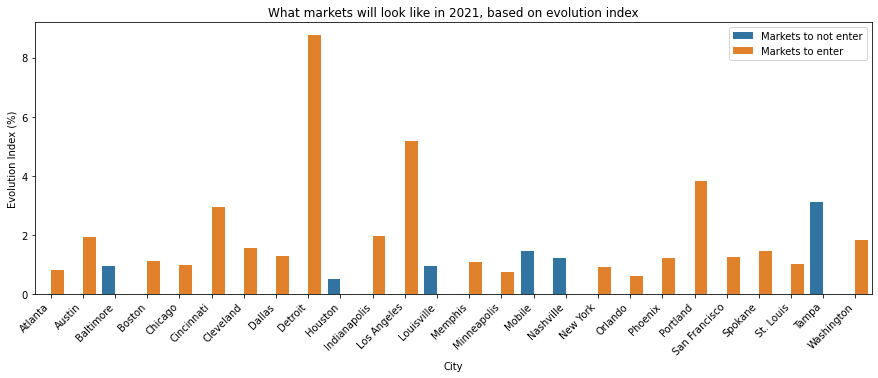

In [240]:
plt.figure(figsize=(15,5))
ax = sns.barplot(data=predictions, x="city", y="ei", hue="label")
plt.title("What markets will look like in 2021, based on evolution index")
plt.xticks(rotation=45, ha="right")
plt.xlabel("City")
plt.ylabel("Evolution Index (%)")
new_labels = ['Markets to not enter', 'Markets to enter']
h, l = ax.get_legend_handles_labels()
ax.legend(h, new_labels)
plt.show()

-----
----


# Phase II Modeling

In [246]:
def rename_columns(df):
    """
    Docstring
    """
    
    # rename columns inplace
    df.rename(
        columns={
            "Date": "survey_date",
            "Code": "csa_code",
            "Code.1": "cbsa_code",
            "Unnamed: 3": "moncov",
            "Name": "cbsa_name",
            "Bldgs": "one_unit_bldgs_est",
            "Units": "one_unit_units_est",
            "Value": "one_unit_value_est",
            "Bldgs.1": "two_units_bldgs_est",
            "Units.1": "two_units_units_est",
            "Value.1": "two_units_value_est",
            "Bldgs.2": "three_to_four_units_bldgs_est",
            "Units.2": "three_to_four_units_units_est",
            "Value.2": "three_to_four_units_value_est",
            "Bldgs.3": "five_or_more_units_bldgs_est",
            "Units.3": "five_or_more_units_units_est",
            "Value.3": "five_or_more_units_value_est",
            "Bldgs.3": "five_or_more_units_bldgs_est",
            "Units.3": "five_or_more_units_units_est",
            "Value.3": "five_or_more_units_value_est",
            "Bldgs.4": "one_unit_bldgs_rep",
            "Units.4": "one_unit_units_rep",
            "Value.4": "one_unit_value_rep",
            "Bldgs.5": "two_units_bldgs_rep",
            "Units.5": "two_units_units_rep",
            "Value.5": "two_units_value_rep",
            "      Bldgs": "three_to_four_units_bldgs_rep",
            "Units.6": "three_to_four_units_units_rep",
            "Value.6": "three_to_four_units_value_rep",
            "Bldgs.6": "five_or_more_units_bldgs_rep",
            "Units.7": "five_or_more_units_units_rep",
            "Value.7": "five_or_more_units_value_rep",
        },
        inplace=True,
        )
    
    return df

In [247]:
def acquire_building_permits():
    """
    Docstring
    """
    
    # conditional
    if path.exists("building_permits.csv"):
        
        # read csv
        df = pd.read_csv("building_permits.csv", index_col=0)
        
    else:
    
        # create original df with 2019 data
        df = pd.read_csv("https://www2.census.gov/econ/bps/Metro/ma2019a.txt", sep=",", header=1)

        # rename columns
        rename_columns(df)

        for i in range(1980, 2019):

            # read the txt file at url where i is the year in range
            year_df = pd.read_csv(
                f"https://www2.census.gov/econ/bps/Metro/ma{i}a.txt",
                sep=",",
                header=1,
                names=df.columns.tolist(),
            )
            
            # append data to global df variable
            df = df.append(year_df, ignore_index=True)

        # make moncov into bool so that the null observations of this feature are not considered in the dropna below
        df["moncov"] = np.where(df.moncov == "C", 1, 0)

        # dropna inplace
        df.dropna(inplace=True)
        
        # chop off the succeding two digits after the year for survey_date
        df["survey_date"] = df.survey_date.astype(str).apply(lambda x: re.sub(r"\d\d$", "", x))
        
        # add a preceding "19" to any years where the length of the observation is 2 (e.i., "80"-"97")
        df["survey_date"] = df.survey_date.apply(lambda x: "19" + x if len(x) == 2 else x)
        
        # turn survey_date back into an int
        df["survey_date"] = df.survey_date.astype(int)
        
        # turn moncov back into a bool
        df["moncov"] = df.moncov.astype(bool)
        
        # sort values by survey_date
        df.sort_values(by=["survey_date"])
        
        # reset index inplace
        df.reset_index(inplace=True)
        
        # drop former index inplace
        df.drop(columns=["index"], inplace=True)
        
        # write df to disk as csv
        df.to_csv("building_permits.csv")
    
    return df

In [384]:
df_model = acquire_building_permits()
print(f"""Our DataFrame contains {df_model.shape[0]:,} observations and {df_model.shape[1]} features.""")
df_model

Our DataFrame contains 14,149 observations and 29 features.


,survey_date,csa_code,cbsa_code,moncov,cbsa_name,one_unit_bldgs_est,one_unit_units_est,one_unit_value_est,two_units_bldgs_est,two_units_units_est,...,one_unit_value_rep,two_units_bldgs_rep,two_units_units_rep,two_units_value_rep,three_to_four_units_bldgs_rep,three_to_four_units_units_rep,three_to_four_units_value_rep,five_or_more_units_bldgs_rep,five_or_more_units_units_rep,five_or_more_units_value_rep
0,2019,104.0,10580.0,True,Albany-Schenectady-Troy NY,1120.0,1120.0,309397.0,20.0,40.0,...,268946.0,18.0,36.0,6544.0,12.0,45.0,6074.0,34.0,580.0,56469.0
1,2019,104.0,24020.0,False,Glens Falls NY,229.0,229.0,57598.0,0.0,0.0,...,37724.0,0.0,0.0,0.0,2.0,6.0,746.0,1.0,6.0,781.0
2,2019,106.0,10740.0,True,Albuquerque NM,1872.0,1872.0,446893.0,1.0,2.0,...,296615.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,188.0,20079.0
3,2019,106.0,42140.0,True,Santa Fe NM,344.0,344.0,78685.0,0.0,0.0,...,78685.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,245.0,30037.0
4,2019,107.0,11020.0,False,Altoona PA,111.0,111.0,24333.0,0.0,0.0,...,22834.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14144,2018,999.0,48540.0,False,Wheeling WV-OH,9.0,9.0,1435.0,2.0,4.0,...,1327.0,2.0,4.0,300.0,1.0,3.0,270.0,1.0,100.0,12500.0
14145,2018,999.0,48660.0,False,Wichita Falls TX,117.0,117.0,26725.0,4.0,8.0,...,26725.0,4.0,8.0,420.0,0.0,0.0,0.0,8.0,195.0,17999.0
14146,2018,999.0,48900.0,False,Wilmington NC,1868.0,1868.0,521252.0,16.0,32.0,...,405914.0,12.0,24.0,4802.0,5.0,20.0,1956.0,14.0,473.0,69781.0
14147,2018,999.0,49420.0,False,Yakima WA,480.0,480.0,111572.0,16.0,32.0,...,106541.0,16.0,32.0,4670.0,14.0,51.0,7210.0,2.0,15.0,1609.0


In [385]:
df_model.sort_values(by=["survey_date"], ascending=False)

,survey_date,csa_code,cbsa_code,moncov,cbsa_name,one_unit_bldgs_est,one_unit_units_est,one_unit_value_est,two_units_bldgs_est,two_units_units_est,...,one_unit_value_rep,two_units_bldgs_rep,two_units_units_rep,two_units_value_rep,three_to_four_units_bldgs_rep,three_to_four_units_units_rep,three_to_four_units_value_rep,five_or_more_units_bldgs_rep,five_or_more_units_units_rep,five_or_more_units_value_rep
0,2019,104.0,10580.0,True,Albany-Schenectady-Troy NY,1120.0,1120.0,309397.0,20.0,40.0,...,268946.0,18.0,36.0,6544.0,12.0,45.0,6074.0,34.0,580.0,56469.0
193,2019,430.0,48260.0,False,Weirton-Steubenville WV-OH,25.0,25.0,5782.0,0.0,0.0,...,5782.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
263,2019,999.0,10180.0,False,Abilene TX,354.0,354.0,72824.0,8.0,16.0,...,72596.0,8.0,16.0,2093.0,0.0,0.0,0.0,0.0,0.0,0.0
262,2019,566.0,49660.0,False,Youngstown-Warren-Boardman OH-PA,323.0,323.0,73182.0,2.0,4.0,...,50054.0,2.0,4.0,407.0,1.0,3.0,467.0,0.0,0.0,0.0
261,2019,558.0,48700.0,False,Williamsport PA,66.0,66.0,16215.0,6.0,12.0,...,12095.0,6.0,12.0,1610.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,1980,5745.0,9999.0,False,NORTHEAST PENNSYLVANIA SMSA,1146.0,1146.0,42642.0,3.0,6.0,...,39843.0,3.0,6.0,91.0,6.0,23.0,440.0,5.0,627.0,15798.0
566,1980,5720.0,9999.0,False,NORFOLK-VIRGINIA BEACH-,2806.0,2806.0,146250.0,110.0,220.0,...,146250.0,110.0,220.0,6606.0,61.0,231.0,7896.0,201.0,1521.0,44621.0
565,1980,5680.0,9999.0,False,NEWPORT NEWS-HAMPTON SMSA,1435.0,1435.0,65952.0,2.0,4.0,...,65952.0,2.0,4.0,30.0,0.0,0.0,0.0,25.0,192.0,3146.0
564,1980,5640.0,9999.0,False,NEWARK SMSA,2156.0,2156.0,137423.0,59.0,118.0,...,137349.0,59.0,118.0,3407.0,13.0,47.0,1927.0,32.0,1343.0,40208.0


In [386]:
df_model.survey_date.min(), df_model.survey_date.max()

(1980, 2019)

In [387]:
df_model.survey_date.value_counts().sort_index(ascending=False)

2019    384
2018    382
2017    382
2016    382
2015    381
2014    381
2013    366
2012    366
2011    366
2010    366
2009    366
2008    363
2007    363
2006    361
2005    361
2004    361
2003    361
2002    349
2001    349
2000    349
1999    349
1998    348
1997    346
1996    346
1995    344
1994    342
1993    341
1992    355
1991    355
1990    355
1989    354
1988    353
1987    352
1986    352
1985    352
1984    328
1983    318
1982    318
1981    318
1980    284
Name: survey_date, dtype: int64

In [388]:
df_model.groupby("cbsa_name").five_or_more_units_value_rep.mean()

cbsa_name
ABILENE SMSA                         14871.250000
ABILENE TX MSA. . . . . . . . . .     1850.000000
ABILENE TX. . . . . . . . . . . .    12140.000000
AKRON OH (P). . . . . . . . . . .    13780.000000
AKRON OH PMSA . . . . . . . . . .    15799.500000
                                         ...     
Yuba City CA MSA                      1989.222222
Yuba City CA MSA. . . . . . . . .     7920.000000
Yuma  AZ                              2274.117647
Yuma  AZ MSA                          5409.666667
Yuma AZ MSA                           3112.428571
Name: five_or_more_units_value_rep, Length: 2639, dtype: float64

In [389]:
df_model[(df_model.cbsa_name.str.contains("ABILENE"))]

,survey_date,csa_code,cbsa_code,moncov,cbsa_name,one_unit_bldgs_est,one_unit_units_est,one_unit_value_est,two_units_bldgs_est,two_units_units_est,...,one_unit_value_rep,two_units_bldgs_rep,two_units_units_rep,two_units_value_rep,three_to_four_units_bldgs_rep,three_to_four_units_units_rep,three_to_four_units_value_rep,five_or_more_units_bldgs_rep,five_or_more_units_units_rep,five_or_more_units_value_rep
384,1980,40.0,9999.0,False,ABILENE SMSA,569.0,569.0,40702.0,7.0,14.0,...,40144.0,7.0,14.0,542.0,5.0,20.0,555.0,2.0,352.0,5995.0
668,1981,40.0,9999.0,False,ABILENE SMSA,550.0,550.0,43510.0,20.0,40.0,...,42157.0,20.0,40.0,1831.0,11.0,40.0,1415.0,18.0,268.0,4525.0
986,1982,40.0,9999.0,False,ABILENE SMSA,788.0,788.0,53100.0,27.0,54.0,...,51675.0,27.0,54.0,2539.0,4.0,14.0,505.0,61.0,1280.0,26975.0
1304,1983,40.0,9999.0,False,ABILENE SMSA,1072.0,1072.0,71385.0,69.0,138.0,...,68857.0,69.0,138.0,8556.0,25.0,99.0,2541.0,7.0,744.0,21990.0
1622,1984,40.0,9999.0,False,ABILENE TX. . . . . . . . . . . .,501.0,501.0,36623.0,31.0,62.0,...,34225.0,31.0,62.0,3094.0,24.0,96.0,2070.0,40.0,520.0,12140.0
1950,1985,40.0,9999.0,False,ABILENE TX MSA. . . . . . . . . .,385.0,385.0,32929.0,4.0,8.0,...,31190.0,4.0,8.0,268.0,0.0,0.0,0.0,1.0,65.0,3000.0
2302,1986,40.0,9999.0,False,ABILENE TX MSA. . . . . . . . . .,335.0,335.0,28675.0,1.0,2.0,...,26230.0,1.0,2.0,124.0,3.0,12.0,599.0,1.0,10.0,700.0


In [390]:
df_model[df_model.survey_date > 1998].sort_values(by = "survey_date", ascending=True).cbsa_name.value_counts().tail(60)

Los Angeles-Long Beach  CA PMSA                   4
Phoenix-Mesa-Glendale  AZ                         4
Bakersfield-Delano  CA                            4
Yolo  CA PMSA                                     4
Cedar Rapids  IA MSA                              4
Dutchess County  NY PMSA                          4
Lansing-East Lansing  MI MSA                      4
Salem  OR PMSA                                    4
San Francisco-Oakland-San Jose  CA CMSA           4
Gary  IN PMSA                                     4
Pittsfield  MA MSA                                4
Newburgh  NY-PA PMSA                              4
Laredo  TX MSA                                    4
Dover  DE MSA                                     4
South Bend  IN MSA                                4
Baton Rouge  LA MSA                               4
Bremerton  WA PMSA                                4
Tallahassee  FL MSA                               4
Chicago  IL PMSA                                  4
Savannah  GA

We need to find the cities that have the most number of continuous data.

In [391]:
(df_model.groupby("cbsa_name").survey_date.count().sort_values() == 17).sum()

260

In [392]:
df_model[df_model["five_or_more_units_value_est"] == 0.0].groupby("cbsa_name").three_to_four_units_value_rep.sum()

cbsa_name
ALBANY SMSA                            92.0
ALEXANDRIA SMSA                      1610.0
ALTOONA PA MSA. . . . . . . . . .       0.0
ALTOONA SMSA                           22.0
ANDERSON IN . . . . . . . . . . .     879.0
                                      ...  
Yuba City  CA                           0.0
Yuba City  CA MSA                       0.0
Yuba City CA MSA                      120.0
Yuma  AZ                             2281.0
Yuma AZ MSA                          1318.0
Name: three_to_four_units_value_rep, Length: 585, dtype: float64

In [393]:
df_model.shape

(14149, 29)

Things that need to get done:

* standarized the name of the cities so that they are all uniform. Need to make sure that when we do a groupby, cities aren't being overlook, or that there are duplicates.
* Can we do a loop using `str.contains()` to add city names together in an effort to standarized the names. Use a double_split ("  ") to create a split between the name and the state

In [394]:
df_model["city"] = df_model.cbsa_name.str.split("  ", 1, expand = True)[0]

In [395]:
df_model["state"] = df_model.cbsa_name.str.split("  ", 1, expand = True)[1]

In [396]:
df_model

,survey_date,csa_code,cbsa_code,moncov,cbsa_name,one_unit_bldgs_est,one_unit_units_est,one_unit_value_est,two_units_bldgs_est,two_units_units_est,...,two_units_units_rep,two_units_value_rep,three_to_four_units_bldgs_rep,three_to_four_units_units_rep,three_to_four_units_value_rep,five_or_more_units_bldgs_rep,five_or_more_units_units_rep,five_or_more_units_value_rep,city,state
0,2019,104.0,10580.0,True,Albany-Schenectady-Troy NY,1120.0,1120.0,309397.0,20.0,40.0,...,36.0,6544.0,12.0,45.0,6074.0,34.0,580.0,56469.0,Albany-Schenectady-Troy,NY
1,2019,104.0,24020.0,False,Glens Falls NY,229.0,229.0,57598.0,0.0,0.0,...,0.0,0.0,2.0,6.0,746.0,1.0,6.0,781.0,Glens Falls,NY
2,2019,106.0,10740.0,True,Albuquerque NM,1872.0,1872.0,446893.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,2.0,188.0,20079.0,Albuquerque,NM
3,2019,106.0,42140.0,True,Santa Fe NM,344.0,344.0,78685.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.0,245.0,30037.0,Santa Fe,NM
4,2019,107.0,11020.0,False,Altoona PA,111.0,111.0,24333.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Altoona,PA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14144,2018,999.0,48540.0,False,Wheeling WV-OH,9.0,9.0,1435.0,2.0,4.0,...,4.0,300.0,1.0,3.0,270.0,1.0,100.0,12500.0,Wheeling,WV-OH
14145,2018,999.0,48660.0,False,Wichita Falls TX,117.0,117.0,26725.0,4.0,8.0,...,8.0,420.0,0.0,0.0,0.0,8.0,195.0,17999.0,Wichita Falls,TX
14146,2018,999.0,48900.0,False,Wilmington NC,1868.0,1868.0,521252.0,16.0,32.0,...,24.0,4802.0,5.0,20.0,1956.0,14.0,473.0,69781.0,Wilmington,NC
14147,2018,999.0,49420.0,False,Yakima WA,480.0,480.0,111572.0,16.0,32.0,...,32.0,4670.0,14.0,51.0,7210.0,2.0,15.0,1609.0,Yakima,WA


In [397]:
df_model.state.str.split(" ", 1, expand= True)[1].value_counts()

            6281
MSA         1533
PMSA         438
CMSA         108
 AR           11
 AR MSA        6
Name: 1, dtype: int64

In [398]:
df_model[df_model.state.str.contains(" AR") == True]

,survey_date,csa_code,cbsa_code,moncov,cbsa_name,one_unit_bldgs_est,one_unit_units_est,one_unit_value_est,two_units_bldgs_est,two_units_units_est,...,two_units_units_rep,two_units_value_rep,three_to_four_units_bldgs_rep,three_to_four_units_units_rep,three_to_four_units_value_rep,five_or_more_units_bldgs_rep,five_or_more_units_units_rep,five_or_more_units_value_rep,city,state
6452,1997,8360.0,9999.0,False,Texarkana TX-Texarkana AR MSA,170.0,170.0,11657.0,2.0,4.0,...,4.0,175.0,1.0,4.0,137.0,0.0,0.0,0.0,Texarkana,TX-Texarkana AR MSA
6800,1998,8360.0,9999.0,False,Texarkana TX-Texarkana AR MSA,155.0,155.0,11127.0,2.0,4.0,...,4.0,181.0,0.0,0.0,0.0,0.0,0.0,0.0,Texarkana,TX-Texarkana AR MSA
7149,1999,8360.0,9999.0,False,Texarkana TX-Texarkana AR MSA,214.0,214.0,16882.0,3.0,6.0,...,6.0,213.0,0.0,0.0,0.0,1.0,144.0,5000.0,Texarkana,TX-Texarkana AR MSA
7498,2000,8360.0,9999.0,False,Texarkana TX-Texarkana AR MSA,263.0,263.0,19044.0,0.0,0.0,...,0.0,0.0,39.0,156.0,3965.0,0.0,0.0,0.0,Texarkana,TX-Texarkana AR MSA
7847,2001,8360.0,9999.0,False,Texarkana TX-Texarkana AR MSA,220.0,220.0,20524.0,11.0,22.0,...,22.0,843.0,0.0,0.0,0.0,0.0,0.0,0.0,Texarkana,TX-Texarkana AR MSA
8196,2002,8360.0,9999.0,False,Texarkana TX-Texarkana AR MSA,224.0,224.0,19162.0,10.0,20.0,...,20.0,1133.0,0.0,0.0,0.0,12.0,144.0,3300.0,Texarkana,TX-Texarkana AR MSA
8582,2003,999.0,45500.0,False,Texarkana TX-Texarkana AR,276.0,276.0,28107.0,48.0,96.0,...,96.0,4615.0,2.0,7.0,350.0,24.0,272.0,12388.0,Texarkana,TX-Texarkana AR
8943,2004,999.0,45500.0,False,Texarkana TX-Texarkana AR,251.0,251.0,24429.0,36.0,72.0,...,72.0,3143.0,0.0,0.0,0.0,1.0,8.0,290.0,Texarkana,TX-Texarkana AR
9305,2005,999.0,45500.0,False,Texarkana TX-Texarkana AR,220.0,220.0,24143.0,14.0,28.0,...,28.0,1339.0,0.0,0.0,0.0,0.0,0.0,0.0,Texarkana,TX-Texarkana AR
9666,2006,999.0,45500.0,False,Texarkana TX-Texarkana AR,199.0,199.0,21171.0,12.0,24.0,...,24.0,1484.0,1.0,3.0,130.0,0.0,0.0,0.0,Texarkana,TX-Texarkana AR


In [399]:
df_model[(df_model.city.str.contains("Dallas") == True) & (df_model.survey_date > 2000)].sort_values(by="survey_date", ascending=True)

,survey_date,csa_code,cbsa_code,moncov,cbsa_name,one_unit_bldgs_est,one_unit_units_est,one_unit_value_est,two_units_bldgs_est,two_units_units_est,...,two_units_units_rep,two_units_value_rep,three_to_four_units_bldgs_rep,three_to_four_units_units_rep,three_to_four_units_value_rep,five_or_more_units_bldgs_rep,five_or_more_units_units_rep,five_or_more_units_value_rep,city,state
7617,2001,1922.0,1920.0,False,Dallas TX PMSA,25689.0,25689.0,4190214.0,35.0,70.0,...,50.0,4698.0,32.0,122.0,15856.0,425.0,9567.0,485255.0,Dallas,TX PMSA
7878,2001,1922.0,9999.0,False,Dallas-Fort Worth TX CMSA,37858.0,37858.0,5692103.0,77.0,154.0,...,118.0,8679.0,54.0,210.0,19493.0,533.0,11586.0,586747.0,Dallas-Fort Worth,TX CMSA
7966,2002,1922.0,1920.0,False,Dallas TX PMSA,24944.0,24944.0,4179878.0,67.0,134.0,...,134.0,13534.0,160.0,635.0,31581.0,405.0,8747.0,442862.0,Dallas,TX PMSA
8227,2002,1922.0,9999.0,False,Dallas-Fort Worth TX CMSA,38309.0,38309.0,6004303.0,115.0,230.0,...,214.0,17935.0,235.0,934.0,48212.0,627.0,12102.0,635553.0,Dallas-Fort Worth,TX CMSA
8272,2003,206.0,19100.0,True,Dallas-Fort Worth-Arlington TX,40537.0,40537.0,6447004.0,116.0,232.0,...,220.0,16551.0,170.0,661.0,22087.0,576.0,11206.0,611339.0,Dallas-Fort Worth-Arlington,TX
8633,2004,206.0,19100.0,True,Dallas-Fort Worth-Arlington TX,45908.0,45908.0,7543649.0,154.0,308.0,...,294.0,17668.0,28.0,103.0,8685.0,381.0,7470.0,428709.0,Dallas-Fort Worth-Arlington,TX
8994,2005,206.0,19100.0,True,Dallas-Fort Worth-Arlington TX,49489.0,49489.0,8591102.0,221.0,442.0,...,430.0,23899.0,40.0,149.0,12872.0,500.0,9760.0,692993.0,Dallas-Fort Worth-Arlington,TX
9355,2006,206.0,19100.0,True,Dallas-Fort Worth-Arlington TX,43591.0,43591.0,8442367.0,298.0,596.0,...,590.0,40524.0,86.0,329.0,40238.0,456.0,11998.0,979997.0,Dallas-Fort Worth-Arlington,TX
9716,2007,206.0,19100.0,True,Dallas-Fort Worth-Arlington TX,28156.0,28156.0,5995555.0,186.0,372.0,...,364.0,32233.0,135.0,528.0,38943.0,484.0,14433.0,1227385.0,Dallas-Fort Worth-Arlington,TX
10079,2008,206.0,19100.0,True,Dallas-Fort Worth-Arlington TX,17919.0,17919.0,3908916.0,101.0,202.0,...,202.0,17367.0,59.0,234.0,23782.0,581.0,17645.0,1181978.0,Dallas-Fort Worth-Arlington,TX


In [400]:
df_model["major_city"] = df_model.city.str.split("-", 1, expand=True)[0]

In [401]:
df_model["major_state"] = df_model.state.str.split("-", 1, expand=True)[0]

In [402]:
df_model["metropolitan_area"] = df_model.state.str.split("-", 1, expand=True)[1]

In [403]:
df_model["metropolitan_area"] = df_model.major_state.str.split(" ", 1, expand=True)[1]

In [404]:
df_model["major_state"] = df_model.major_state.str.split(" ", 1, expand=True)[0]

In [405]:
df_model[df_model.metropolitan_area == "MSA "].groupby("major_state").sum()

,survey_date,csa_code,cbsa_code,moncov,one_unit_bldgs_est,one_unit_units_est,one_unit_value_est,two_units_bldgs_est,two_units_units_est,two_units_value_est,...,one_unit_value_rep,two_units_bldgs_rep,two_units_units_rep,two_units_value_rep,three_to_four_units_bldgs_rep,three_to_four_units_units_rep,three_to_four_units_value_rep,five_or_more_units_bldgs_rep,five_or_more_units_units_rep,five_or_more_units_value_rep
major_state,,,,,,,,,,,,,,,,,,,,,
AK,11997,2280.0,59994.0,False,5775.0,5775.0,1090311.0,924.0,1848.0,240360.0,...,1073589.0,919.0,1838.0,239133.0,171.0,636.0,70448.0,120.0,1227.0,120704.0
AL,117973,192500.0,589941.0,False,75653.0,75653.0,8420009.0,503.0,1006.0,58361.0,...,8113143.0,497.0,994.0,57789.0,262.0,988.0,45754.0,1168.0,17847.0,961496.0
AR,47988,101520.0,239976.0,False,29810.0,29810.0,3553068.0,551.0,1102.0,61345.0,...,3478313.0,519.0,1038.0,58782.0,386.0,1491.0,69151.0,1000.0,11457.0,420727.0
AZ,35991,144480.0,179982.0,False,263918.0,263918.0,34847175.0,811.0,1622.0,124341.0,...,34647516.0,809.0,1618.0,124261.0,865.0,3174.0,252023.0,4765.0,62193.0,3421859.0
Al,11997,12180.0,59994.0,False,2162.0,2162.0,232483.0,4.0,8.0,240.0,...,211382.0,1.0,2.0,60.0,36.0,136.0,4992.0,7.0,99.0,2963.0
CA,155961,465360.0,779922.0,False,185347.0,185347.0,30363749.0,859.0,1718.0,170654.0,...,29928861.0,829.0,1658.0,166450.0,1566.0,5383.0,453781.0,2127.0,32792.0,2628530.0
CO,47988,83670.0,239976.0,False,56521.0,56521.0,6682614.0,633.0,1266.0,80830.0,...,6645842.0,631.0,1262.0,80641.0,374.0,1420.0,88185.0,798.0,11420.0,659632.0
CT,11997,19680.0,59994.0,False,19540.0,19540.0,2416708.0,181.0,362.0,22544.0,...,2344308.0,181.0,362.0,22544.0,60.0,228.0,12679.0,178.0,2301.0,94732.0
DE,11997,13140.0,59994.0,False,5255.0,5255.0,511242.0,10.0,20.0,964.0,...,508129.0,10.0,20.0,964.0,7.0,28.0,879.0,11.0,278.0,17139.0
